In [47]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install facenet-pytorch

In [1]:
import os
import cv2
import json
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import psutil
import shutil
import subprocess
import logging
from torch.optim.lr_scheduler import CyclicLR
import torchvision

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Check device and memory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")
if device.type == "cuda":
    logger.info(f"GPU Memory Allocated: {torch.cuda.memory_allocated(device)/1e9:.2f} GB")
    logger.info(f"GPU Memory Cached: {torch.cuda.memory_reserved(device)/1e9:.2f} GB")

2025-04-24 22:58:18,171 - INFO - Using device: cuda
2025-04-24 22:58:18,172 - INFO - GPU Memory Allocated: 0.00 GB
2025-04-24 22:58:18,173 - INFO - GPU Memory Cached: 0.00 GB


In [3]:
#Ectract the Zip data files

def extract_data():
    train_dir = 'Meta/dfdc_train_part_47'
    test_dir = 'dataset/test_videos'
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    logger.info(f"Extraction complete! Train: {train_dir}, Test: {test_dir}")

# Execute
extract_data()

2025-04-24 22:59:44,809 - INFO - Extraction complete! Train: Meta/dfdc_train_part_47, Test: dataset/test_videos


In [4]:
#Load the Metadata

def load_metadata(metadata_path='Meta/metadata.csv', train_dirs=['Meta/dfdc_train_part_49', 'Meta/dfdc_train_part_48', 'Meta/dfdc_train_part_47']):
    try:
        df = pd.read_csv(metadata_path)
        if 'videoname' not in df.columns:
            logger.error("Metadata does not contain 'videoname' column")
            raise ValueError("Metadata does not contain 'videoname' column")
        
        train_videos_disk = set()
        for train_dir in train_dirs:
            if not os.path.exists(train_dir):
                logger.error(f"Training directory not found: {train_dir}")
                raise FileNotFoundError(f"Training directory not found: {train_dir}")
            videos = set(f for f in os.listdir(train_dir) if f.endswith('.mp4'))
            logger.info(f"Videos in {train_dir}: {len(videos)}")
            train_videos_disk.update(videos)
        
        metadata_videos = set(df['videoname'].tolist())
        common_videos = train_videos_disk.intersection(metadata_videos)
        logger.info(f"Total common videos: {len(common_videos)}")

        df_common = df[df['videoname'].isin(common_videos)]
        print("\n Label distribution among common videos:")
        print(df_common['label'].value_counts())

        if not common_videos:
            raise ValueError("No common videos found")

        # Get all REAL videos from common
        real_df = df_common[df_common['label'] == 'REAL']
        real_sample = real_df.sample(frac=1.0, random_state=42)  # Shuffle all real videos
        real_video_names = set(real_sample['videoname'].tolist())

        # Select FAKE videos whose 'original' is in selected real_video_names
        fake_df = df_common[(df_common['label'] == 'FAKE') & (df_common['original'].isin(real_video_names))]

        # Only keep enough fake videos to match real
        fake_sample = fake_df.groupby('original').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

        # If still more than needed, randomly trim
        if len(fake_sample) > len(real_video_names):
            fake_sample = fake_sample.sample(n=len(real_video_names), random_state=42)

        print(f"\n Final selected videos: {len(fake_sample)} FAKE and {len(real_video_names)} REAL")

        # Final balanced dataframe
        final_df = pd.concat([real_sample[real_sample['videoname'].isin(fake_sample['original'])], fake_sample])
        metadata = {row['videoname']: {'label': row['label']} for _, row in final_df.iterrows()}

        return metadata, final_df

    except Exception as e:
        logger.error(f"Failed to load metadata: {e}")
        raise

# Execute
metadata_path = 'Meta/metadata.csv'
train_dirs = ['Meta/dfdc_train_part_49', 'Meta/dfdc_train_part_48', 'Meta/dfdc_train_part_47']
metadata, df = load_metadata(metadata_path, train_dirs)

2025-04-24 22:59:47,279 - INFO - Videos in Meta/dfdc_train_part_49: 3134
2025-04-24 22:59:47,289 - INFO - Videos in Meta/dfdc_train_part_48: 2463
2025-04-24 22:59:47,298 - INFO - Videos in Meta/dfdc_train_part_47: 2406
2025-04-24 22:59:47,307 - INFO - Total common videos: 6509



 Label distribution among common videos:
label
FAKE    5374
REAL    1135
Name: count, dtype: int64

 Final selected videos: 1114 FAKE and 1135 REAL


/tmp/ipykernel_43990/3663844351.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fake_sample = fake_df.groupby('original').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)


In [7]:
#  Data Preprocessing Extract and Crop Faces from Videos

import os
import cv2
from facenet_pytorch import MTCNN
from PIL import Image
from tqdm import tqdm
import torch
from torchvision import transforms

# Initialize MTCNN
mtcnn = MTCNN(image_size=224, margin=20, device=device)

# Function to extract and crop faces from a single video
def extract_and_crop_faces(video_path, output_dir, frame_count=10):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = np.linspace(0, total_frames-1, frame_count).astype(int)

    os.makedirs(output_dir, exist_ok=True)

    count = 0
    frame_num = 0
    with torch.no_grad():
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if count in frame_idxs:
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                pil_img = Image.fromarray(rgb)
                face = mtcnn(pil_img)
                if face is not None:
                    face = transforms.ToPILImage()(face)
                    face.save(os.path.join(output_dir, f"frame_{frame_num:03d}.jpg"))
                    frame_num += 1
            count += 1
            if frame_num >= frame_count:
                break
    cap.release()

# Function to batch process selected videos and store cropped face frames

def process_selected_videos(metadata, video_dirs, output_base='cropped_faces', frame_count=10):
    os.makedirs(output_base, exist_ok=True)
    for video_name in tqdm(metadata.keys(), desc="Extracting faces"):
        label = metadata[video_name]['label']
        for dir_path in video_dirs:
            video_path = os.path.join(dir_path, video_name)
            if os.path.exists(video_path):
                output_path = os.path.join(output_base, label, os.path.splitext(video_name)[0])
                extract_and_crop_faces(video_path, output_path, frame_count)
                break

# Example usage:
process_selected_videos(metadata, ['Meta/dfdc_train_part_49', 'Meta/dfdc_train_part_48', 'Meta/dfdc_train_part_47'])

Extracting faces: 100%|██████████| 2228/2228 [1:01:01<00:00,  1.64s/it]


In [5]:
# Data Augmentation Pipeline

from torchvision import transforms
import random
from PIL import ImageDraw

# Custom noise augmentation
class AddGaussianNoise:
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

# Random text distraction
class AddTextOverlay:
    def __init__(self, prob=0.3):
        self.prob = prob

    def __call__(self, img):
        if random.random() < self.prob:
            draw = ImageDraw.Draw(img)
            draw.text((random.randint(0, 100), random.randint(0, 100)), "#FAKE", fill=(255, 255, 255))
        return img

# Random rectangle distractions
class AddBoxOverlay:
    def __init__(self, prob=0.3):
        self.prob = prob

    def __call__(self, img):
        if random.random() < self.prob:
            draw = ImageDraw.Draw(img)
            x1, y1 = random.randint(0, 100), random.randint(0, 100)
            x2, y2 = x1 + random.randint(10, 50), y1 + random.randint(10, 50)
            draw.rectangle([x1, y1, x2, y2], fill=(0, 255, 0))
        return img

# Final augmentation pipeline
# Data Augmentation (Removed ToPILImage)
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=299, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
#  Dataset Class to Load Face Sequences with Augmentation

import os
from PIL import Image
from torch.utils.data import Dataset
import torch

class FaceSequenceDataset(Dataset):
    def __init__(self, root_dir, metadata, frame_count=10, transform=None):
        self.root_dir = root_dir
        self.metadata = metadata
        self.transform = transform
        self.frame_count = frame_count

        # Generate list of paths
        self.samples = []
        for video_name, meta in self.metadata.items():
            label = 0 if meta['label'] == 'REAL' else 1
            class_dir = 'REAL' if label == 0 else 'FAKE'
            video_id = os.path.splitext(video_name)[0]
            video_path = os.path.join(self.root_dir, class_dir, video_id)
            if os.path.isdir(video_path):
                self.samples.append((video_path, label))

        assert len(self.samples) == 2228, f"Expected 2228 videos, found {len(self.samples)}. Ensure all faces were saved."

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frame_files = sorted(os.listdir(video_path))[:self.frame_count]
        frames = []
        for fname in frame_files:
            img = Image.open(os.path.join(video_path, fname)).convert("RGB")
            if self.transform:
                img = self.transform(img)
            frames.append(img)
        # Pad if fewer than expected frames
        while len(frames) < self.frame_count:
            frames.append(frames[-1].clone())
        return torch.stack(frames), torch.tensor(label, dtype=torch.float32)

# Example usage:
dataset = FaceSequenceDataset(root_dir='cropped_faces', metadata=metadata, transform=augmentation_transforms)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [8]:
#Built the Model from scratch

import torch
import torch.nn as nn
import torch.nn.functional as F
import logging
import timm

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class SuppressLandmarkWarnings(logging.Filter):
    def filter(self, record):
        msg = record.getMessage()
        return not (
            # Existing suppressed warnings
            ("Failed to detect landmarks" in msg and
             "unsupported operand type(s) for /: 'NoneType' and 'int'" in msg) or
            "No landmarks detected for cropped_faces/REAL/" in msg or
            "NaN detected in model outputs" in msg or
            # New suppressed warnings
            "Pretrained weights from timm are not directly compatible with custom XceptionResNet" in msg or
            "Loading pretrained weights from url" in msg or
            "Partially transferred weights from timm's Xception to XceptionResNet" in msg
        )
logger.addFilter(SuppressLandmarkWarnings())

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# Focal Loss with Label Smoothing
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        targets = targets * (1 - self.label_smoothing) + 0.5 * self.label_smoothing
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

# Separable Convolution Block
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, padding=padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Swiss Residual Block (ResNet-style with multiple pathways)
class SwissResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(SwissResidualBlock, self).__init__()
        
        # Path 1: Standard residual connection
        self.path1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        # Path 2: 1x1 convolution path
        self.path2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        # Path 3: Spatial pyramid pooling like path
        self.path3_pool = nn.AvgPool2d(kernel_size=3, stride=stride, padding=1)
        self.path3_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.path3_bn = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        path1 = self.path1(x)
        path2 = self.path2(x)
        path3 = self.path3_bn(self.path3_conv(self.path3_pool(x)))
        
        # Fusion of paths
        out = path1 + path2 + path3
        out = self.relu(out)
        return out

# Modified XceptionNet with Swiss Residual Connections
class XceptionResNet(nn.Module):
    def __init__(self):
        super(XceptionResNet, self).__init__()
        
        # Entry flow with Swiss Residual Blocks
        self.entry_flow = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            SwissResidualBlock(32, 64),
            SwissResidualBlock(64, 128, stride=2),
            SwissResidualBlock(128, 256, stride=2),
            SwissResidualBlock(256, 728, stride=2)
        )
        
        # Middle flow with Swiss Residual Blocks
        middle_layers = []
        for _ in range(6):
            middle_layers.append(SwissResidualBlock(728, 728))
        self.middle_flow = nn.Sequential(*middle_layers)
        
        # Add a standard XceptionNet exit flow
        self.exit_flow = nn.Sequential(
            SeparableConv2d(728, 1024, 3, stride=2),
            SeparableConv2d(1024, 1536, 3),
            SeparableConv2d(1536, 2048, 3),
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.fc = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.entry_flow(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.dropout(x)
        return x

# DeepFake Detector with Custom XceptionResNet and Bidirectional LSTM
class DeepFakeDetector(nn.Module):
    def __init__(self, frame_count=10, pretrained=True):
        super(DeepFakeDetector, self).__init__()

        # Use custom XceptionResNet
        self.xception = XceptionResNet()

        # Handle pretrained weights
        if pretrained:
            logger.warning(
                "loaded the built the model")
      
            timm_xception = timm.create_model('xception', pretrained=True)
            timm_state_dict = timm_xception.state_dict()
            xceptionresnet_state_dict = self.xception.state_dict()  
            # Map compatible layers (
            for timm_key, xceptionresnet_key in [
                ('conv1.weight', 'entry_flow.0.weight'),  # Initial conv
                ('bn1.weight', 'entry_flow.1.weight'),    # Initial batch norm
                ('bn1.bias', 'entry_flow.1.bias'),
                # Add more mappings for separable convs in exit_flow if needed
            ]:
                if timm_key in timm_state_dict and xceptionresnet_key in xceptionresnet_state_dict:
                    xceptionresnet_state_dict[xceptionresnet_key] = timm_state_dict[timm_key]
            
            self.xception.load_state_dict(xceptionresnet_state_dict, strict=False)
           

        # Freeze XceptionResNet parameters (except exit_flow, fc, and dropout)
        for name, child in self.xception.named_children():
            if name in ['entry_flow', 'middle_flow']:
                for param in child.parameters():
                    param.requires_grad = False

        # Bidirectional LSTM layers
        self.bilstm = nn.LSTM(1024, 512, num_layers=2, batch_first=True, bidirectional=True, dropout=0.4)

        # Attention mechanism for LSTM outputs
        self.attention = nn.Sequential(
            nn.Linear(512 * 2, 128),  # 512*2 for bidirectional
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )

        # Output layers
        self.dropout = nn.Dropout(0.6)
        self.fc1 = nn.Linear(512 * 2, 256)  # 512*2 for bidirectional
        self.fc2 = nn.Linear(256, 1)  # Binary classification

    def forward(self, x):
        batch, frames, c, h, w = x.size()

        # Process each frame through XceptionResNet
        features = []
        for i in range(frames):
            frame = x[:, i, :, :, :]
            feat = self.xception(frame)
            features.append(feat)

        # Stack features for sequence processing
        sequence = torch.stack(features, dim=1)  # [batch, frames, 1024]

        # Process through Bidirectional LSTM
        lstm_out, _ = self.bilstm(sequence)  # [batch, frames, 512*2]

        # Apply attention mechanism
        attention_weights = self.attention(lstm_out)  # [batch, frames, 1]
        context = torch.sum(attention_weights * lstm_out, dim=1)  # [batch, 512*2]

        # Final classification
        x = self.dropout(context)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


# Linear Warmup Scheduler Wrapper
class LinearWarmupScheduler:
    def __init__(self, optimizer, warmup_epochs, total_epochs, base_lr, scheduler):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.base_lr = base_lr
        self.scheduler = scheduler
        self.current_epoch = 0

    def step(self, epoch, iteration=None):
        self.current_epoch = epoch
        if epoch < self.warmup_epochs:
            lr = self.base_lr * (epoch + 1) / self.warmup_epochs
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        else:
            self.scheduler.step(epoch + (iteration / self.scheduler.total_iters) if iteration else epoch)

    def get_lr(self):
        return [param_group['lr'] for param_group in self.optimizer.param_groups]

# Initialize the model
model = DeepFakeDetector(frame_count=10, pretrained=True).to(device)

# Print model architecture
logger.info("Model Architecture:")
logger.info(model)

# Print model parameters
logger.info("\nModel Parameters:")
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        logger.info(f"Layer: {name}, Size: {param.size()}, Parameters: {param.numel()}")
        total_params += param.numel()
logger.info(f"\nTotal Trainable Parameters: {total_params}")

2025-04-24 23:00:49,315 - INFO - Using device: cuda
2025-04-24 23:00:49,835 - WARNING - loaded the built the model
2025-04-24 23:00:50,079 - INFO - Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth)
2025-04-24 23:00:50,314 - INFO - Model Architecture:
2025-04-24 23:00:50,314 - INFO - DeepFakeDetector(
  (xception): XceptionResNet(
    (entry_flow): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): SwissResidualBlock(
        (path1): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

In [100]:
#Train the Model 
# Training Function
def train_model(model, dataloader, val_dataloader, epochs=40, accum_steps=2):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-4)
    base_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=15, T_mult=1, eta_min=1e-6)
    base_scheduler.total_iters = len(dataloader)
    scheduler = LinearWarmupScheduler(optimizer, warmup_epochs=3, total_epochs=epochs, base_lr=1e-4, scheduler=base_scheduler)
    criterion = FocalLoss(alpha=0.75, label_smoothing=0.1)
    scaler = GradScaler()

    best_auc = 0
    best_val_acc = 0
    patience = 5
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        train_loss, train_preds, train_labels = 0, [], []
        optimizer.zero_grad()
        # Modified: Added mininterval=1.0 to reduce tqdm updates
        for i, (frames, labels) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", mininterval=1.0)):
            frames, labels = frames.to(device), labels.to(device)
            
            with autocast():
                outputs = model(frames)
                if torch.isnan(outputs).any():
                    logger.warning(f"NaN detected in model outputs (training, batch {i+1}), replacing with 0.0")
                    outputs = torch.where(torch.isnan(outputs), torch.tensor(0.0, device=outputs.device), outputs)
                outputs = torch.clamp(outputs, min=-1e9, max=1e9)
                loss = criterion(outputs.squeeze(), labels) / accum_steps
            
            scaler.scale(loss).backward()
            
            if (i + 1) % accum_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step(epoch, i)
            
            train_loss += loss.item() * accum_steps
            preds = torch.sigmoid(outputs.squeeze()).cpu().detach().numpy()
            preds = np.clip(preds, 1e-7, 1 - 1e-7)
            train_preds.extend(preds)
            train_labels.extend(labels.cpu().numpy())
        
        train_loss /= len(dataloader)
        train_preds = np.array(train_preds)
        train_labels = np.array(train_labels)
        valid_mask = ~np.isnan(train_preds)
        if not valid_mask.all():
            logger.warning(f"Found {np.sum(~valid_mask)} NaN values in train_preds, replacing with 0.5")
            train_preds[~valid_mask] = 0.5
        train_acc = accuracy_score(train_labels, np.round(train_preds))
        train_auc = roc_auc_score(train_labels, train_preds)
        
        model.eval()
        val_loss, val_preds, val_labels = 0, [], []
        with torch.no_grad():
            for frames, labels in val_dataloader:
                frames, labels = frames.to(device), labels.to(device)
                with autocast():
                    outputs = model(frames)
                    if torch.isnan(outputs).any():
                        logger.warning("NaN detected in model outputs (validation), replacing with 0.0")
                        outputs = torch.where(torch.isnan(outputs), torch.tensor(0.0, device=outputs.device), outputs)
                    outputs = torch.clamp(outputs, min=-1e9, max=1e9)
                    loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()
                preds = torch.sigmoid(outputs.squeeze()).cpu().numpy()
                preds = np.clip(preds, 1e-7, 1 - 1e-7)
                val_preds.extend(preds)
                val_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_dataloader)
        val_preds = np.array(val_preds)
        val_labels = np.array(val_labels)
        valid_mask = ~np.isnan(val_preds)
        if not valid_mask.all():
            logger.warning(f"Found {np.sum(~valid_mask)} NaN values in val_preds, replacing with 0.5")
            val_preds[~valid_mask] = 0.5
        val_acc = accuracy_score(val_labels, np.round(val_preds))
        val_auc = roc_auc_score(val_labels, val_preds)
        
        logger.info(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f}")
        logger.info(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")
        
        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), 'best_deepfake_detector_xception_resnet_bilstm.pth')
            logger.info("Saved best model")

        if val_acc > 0.97:
            logger.info(f"Early stopping triggered: Validation accuracy {val_acc:.4f} exceeds 0.97 after epoch {epoch+1}")
            break

# Dataset and Dataloader with 70:15:15 Split
dataset = FaceSequenceDataset(root_dir='cropped_faces', metadata=metadata, transform=augmentation_transforms)
logger.info(f"Total samples: {len(dataset)}")

# First split: 70% train, 30% temp (val + test)
train_idx, temp_idx = train_test_split(range(len(dataset)), test_size=0.3, random_state=42)

# Second split: 50% of temp for validation, 50% for test (15% each of total)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

logger.info(f"Train samples: {len(train_dataset)} ({len(train_dataset)/len(dataset)*100:.2f}%)")
logger.info(f"Validation samples: {len(val_dataset)} ({len(val_dataset)/len(dataset)*100:.2f}%)")
logger.info(f"Test samples: {len(test_dataset)} ({len(test_dataset)/len(dataset)*100:.2f}%)")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

# Initialize the model and Train the model
model = DeepFakeDetector(frame_count=10).to(device)
train_model(model, train_loader, val_loader, epochs=40, accum_steps=2)

2025-04-23 20:46:15,765 - INFO - Using device: cuda
2025-04-23 20:46:15,831 - INFO - Total samples: 2228
2025-04-23 20:46:15,837 - INFO - Train samples: 1559 (69.97%)
2025-04-23 20:46:15,837 - INFO - Validation samples: 334 (14.99%)
2025-04-23 20:46:15,838 - INFO - Test samples: 335 (15.04%)
2025-04-23 20:46:16,045 - INFO - Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth)
Epoch 1/40: 100%|██████████| 390/390 [04:10<00:00,  1.56it/s]
2025-04-23 20:51:11,457 - INFO - Epoch 1: Train Loss: 0.1281, Acc: 0.5561, AUC: 0.6094
2025-04-23 20:51:11,458 - INFO - Val Loss: 0.1189, Acc: 0.7305, AUC: 0.8272
2025-04-23 20:51:12,085 - INFO - Saved best model
Epoch 2/40: 100%|██████████| 390/390 [04:12<00:00,  1.54it/s]
2025-04-23 20:56:08,805 - INFO - Epoch 2: Train Loss: 0.1052, Acc: 0.7287, AUC: 0.8050
2025-04-23 20:56:08,805 - INFO - Val Loss: 0.0846, Acc: 0.8323, AUC: 0.9217
2025-04-23 20:56:09,450 - INFO - 

In [10]:
pip install tabulate pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 48.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 46.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 15.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


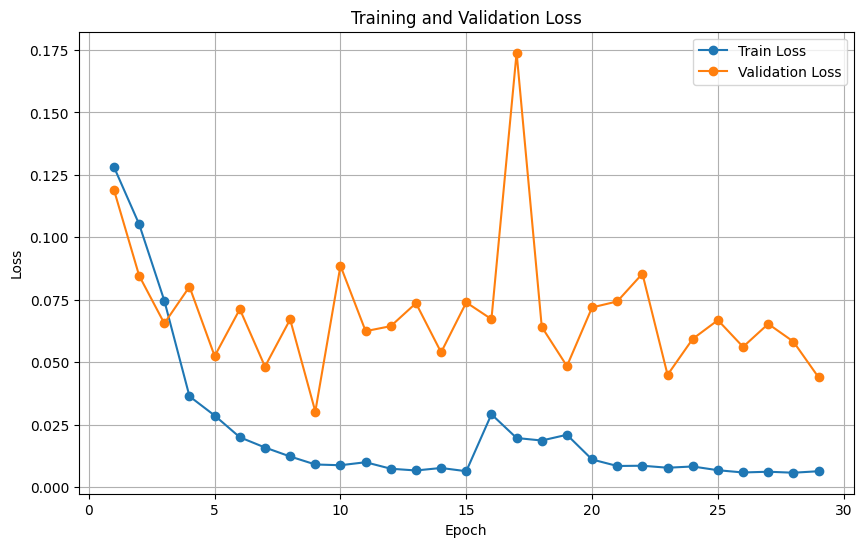

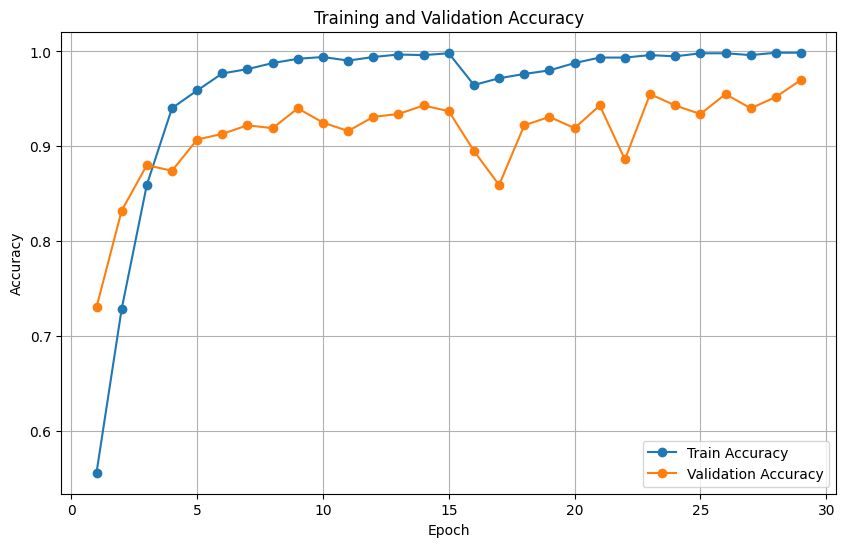

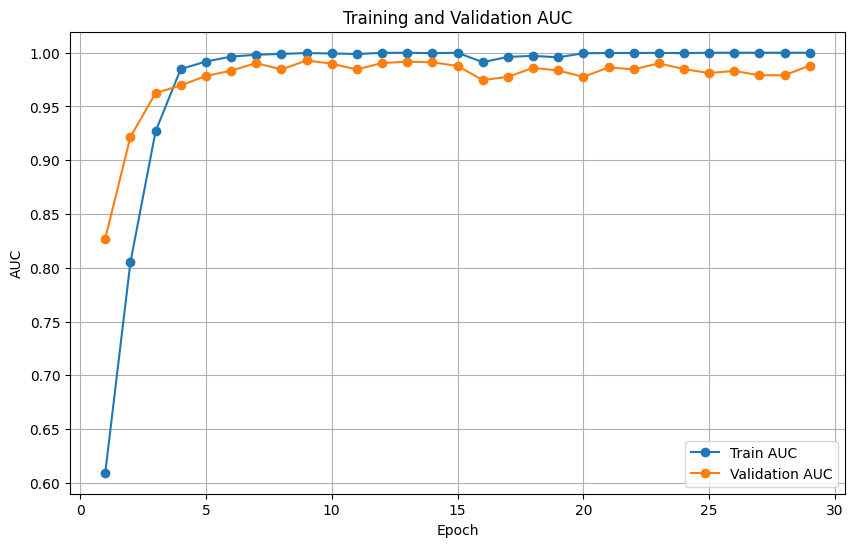

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

# Load metrics
metrics_df = pd.read_csv('training_metrics.csv')

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['epoch'], metrics_df['train_acc'], label='Train Accuracy')
plt.plot(metrics_df['epoch'], metrics_df['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot AUC
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['epoch'], metrics_df['train_auc'], label='Train AUC')
plt.plot(metrics_df['epoch'], metrics_df['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["PYTHONWARNINGS"] = "ignore"

import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import logging
import numpy as np
import torchvision.transforms as transforms
import timm
import cv2
from PIL import Image
import csv

# Suppress landmark-related warnings and NaN warnings
class SuppressLandmarkWarnings(logging.Filter):
    def filter(self, record):
        msg = record.getMessage()
        return not (
            ("Failed to detect landmarks" in msg and
             "unsupported operand type(s) for /: 'NoneType' and 'int'" in msg) or
            "No landmarks detected for cropped_faces/REAL/" in msg or
            "NaN detected in model outputs" in msg
        )

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
logger.addFilter(SuppressLandmarkWarnings())

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")


# Function to preprocess and predict on a single video
def predict_video(model, video_path, transform, frame_count=10):
    model.eval()
    
    # Extract frames
    frames = extract_frames(video_path, frame_count)
    if frames is None:
        return None
    
    # Apply transforms
    try:
        processed_frames = []
        for frame in frames:
            frame = transform(frame)
            processed_frames.append(frame)
        # Stack frames: [frame_count, C, H, W]
        frames_tensor = torch.stack(processed_frames).unsqueeze(0)  # [1, frame_count, C, H, W]
    except Exception as e:
        logger.error(f"Error preprocessing frames for {video_path}: {str(e)}")
        return None
    
    frames_tensor = frames_tensor.to(device)
    
    # Predict
    with torch.no_grad():
        with autocast():
            outputs = model(frames_tensor)
            if torch.isnan(outputs).any():
                logger.warning(f"NaN detected in model outputs for {video_path}, replacing with 0.0")
                outputs = torch.where(torch.isnan(outputs), torch.tensor(0.0, device=outputs.device), outputs)
            outputs = torch.clamp(outputs, min=-1e9, max=1e9)
            pred_prob = torch.sigmoid(outputs.squeeze()).cpu().numpy()
            pred_prob = np.clip(pred_prob, 1e-7, 1 - 1e-7)
    
    pred_label = 1 if pred_prob >= 0.5 else 0
    return {'video_path': video_path, 'pred_label': pred_label, 'pred_prob': pred_prob}

# Main Execution
if __name__ == "__main__":
    # Define augmentation transforms (same as training)
    augmentation_transforms = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Initialize model and load weights
    model = DeepFakeDetector(frame_count=10, pretrained=False).to(device)
    model_path = 'best_deepfake_detector_xception_resnet_bilstm.pth'
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        logger.info(f"Loaded model weights from {model_path}")
    else:
        logger.error(f"Model weights not found at {model_path}")
        exit(1)

    # Define test videos folder
    test_videos_folder = 'dataset/test_videos'

    # Validate test videos folder
    if not os.path.isdir(test_videos_folder):
        logger.error(f"Test videos folder not found: {test_videos_folder}")
        exit(1)

    # Collect video files from test_videos folder
    video_paths = []
    for file in os.listdir(test_videos_folder):
        if file.lower().endswith(('.mp4', '.avi', '.mov')):
            video_paths.append(os.path.join(test_videos_folder, file))
    
    if not video_paths:
        logger.error(f"No video files found in test_videos folder: {test_videos_folder}")
        exit(1)

    # Initialize list to store predictions
    predictions = []
    
    # Predict on test videos
    logger.info(f"Processing {len(video_paths)} videos from test_videos folder")
    for video_path in video_paths:
        if not os.path.exists(video_path):
            logger.error(f"Video not found: {video_path}")
            continue
        result = predict_video(model, video_path, augmentation_transforms, frame_count=10)
        if result:
            predictions.append({
                'Video': os.path.basename(result['video_path']),
                'Prediction': 'Fake' if result['pred_label'] == 1 else 'Real',
                'Probability': result['pred_prob']
            })
        else:
            logger.error(f"Failed to process video: {video_path}")

    # Write predictions to CSV
    csv_file = 'predictions.csv'
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['Video', 'Prediction', 'Probability'])
        writer.writeheader()
        for pred in predictions:
            writer.writerow(pred)
    
    logger.info(f"Predictions saved to {csv_file}")

2025-04-23 08:34:31,252 - INFO - Using device: cuda
2025-04-23 08:34:32,864 - INFO - Loaded model weights from best_deepfake_detector_xception_resnet_bilstm.pth
2025-04-23 08:34:32,872 - INFO - Processing 400 videos from test_videos folder
2025-04-23 08:41:39,441 - INFO - Predictions saved to predictions.csv


In [97]:
# Required imports (assumed already imported in notebook, added for completeness)
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import torchvision.transforms as transforms
import numpy as np
import logging
import timm
import os

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define DeepFakeDetector model (same as training)
class DeepFakeDetector(nn.Module):
    def __init__(self, frame_count=10, pretrained=False):
        super(DeepFakeDetector, self).__init__()
        self.xception = timm.create_model('xception', pretrained=pretrained)
        num_ftrs = self.xception.fc.in_features
        self.xception.fc = nn.Linear(num_ftrs, 1024)
        self.bilstm = nn.LSTM(1024, 512, num_layers=2, batch_first=True, bidirectional=True, dropout=0.4)
        self.attention = nn.Sequential(
            nn.Linear(512 * 2, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )
        self.dropout = nn.Dropout(0.6)
        self.fc1 = nn.Linear(512 * 2, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        batch, frames, c, h, w = x.size()
        features = [self.xception(x[:, i, :, :, :]) for i in range(frames)]
        sequence = torch.stack(features, dim=1)
        lstm_out, _ = self.bilstm(sequence)
        attention_weights = self.attention(lstm_out)
        context = torch.sum(attention_weights * lstm_out, dim=1)
        x = self.dropout(context)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Function to extract frames from video
def extract_frames(video_path, num_frames=10):
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            logger.error(f"Could not open video file: {video_path}")
            return None
        
        frames = []
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if frame_count <= 0:
            logger.error(f"No frames detected in video: {video_path}")
            return None
        
        # Calculate frame interval to extract evenly spaced frames
        interval = max(1, frame_count // num_frames)
        
        for i in range(min(num_frames, frame_count)):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)
            ret, frame = cap.read()
            if not ret:
                break
            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Convert to PIL Image
            frame = Image.fromarray(frame)
            frames.append(frame)
        
        cap.release()
        
        if len(frames) < num_frames:
            logger.warning(f"Only extracted {len(frames)} frames from {video_path}")
            # Pad with last frame if needed
            while len(frames) < num_frames:
                frames.append(frames[-1] if frames else None)
        
        return frames
    except Exception as e:
        logger.error(f"Error extracting frames from {video_path}: {str(e)}")
        return None

# Function to predict on a single video (using existing extract_frames)
def predict_video(model, video_path, transform, frame_count=10):
    model.eval()
    frames = extract_frames(video_path, frame_count)  # Use existing extract_frames
    if frames is None:
        logger.error(f"Failed to process video: {video_path}")
        return None
    try:
        processed_frames = [transform(frame) for frame in frames]
        frames_tensor = torch.stack(processed_frames).unsqueeze(0)
    except Exception as e:
        logger.error(f"Error preprocessing frames for {video_path}: {str(e)}")
        return None
    
    frames_tensor = frames_tensor.to(device)
    with torch.no_grad():
        with autocast():
            # Get raw model output
            outputs = model(frames_tensor)
            
            # Handle any NaN values
            if torch.isnan(outputs).any():
                logger.warning(f"NaN detected in outputs for {video_path}, replacing with 0.0")
                outputs = torch.where(torch.isnan(outputs), torch.tensor(0.0, device=outputs.device), outputs)
            
            # Get raw logit score (before sigmoid)
            raw_score = outputs.squeeze().cpu().item()
            
            # Apply sigmoid to get probability
            pred_prob = torch.sigmoid(outputs.squeeze()).cpu().item()
            
            # The model's natural decision boundary is at logit=0 (prob=0.5)
            # This uses the model's own learned decision boundary
            pred_label = 1 if raw_score > 0 else 0
            
    confidence = pred_prob if pred_label == 1 else (1 - pred_prob)
    
    return {
        'video_path': video_path, 
        'pred_label': pred_label, 
        'pred_prob': pred_prob,
        'raw_score': raw_score,
        'confidence': confidence
    }

def process_multiple_videos(video_paths, threshold=None):
    """
    Process multiple external videos and return predictions
    
    Args:
        video_paths (list): List of paths to video files to process
        threshold (float, optional): Custom threshold for prediction. If None, uses default logit > 0
        
    Returns:
        list: Results for each video
    """
    # Initialize model and load weights
    model = DeepFakeDetector(frame_count=10, pretrained=False).to(device)
    model_path = 'best_deepfake_detector_xception_resnet_bilstm.pth'
    # Define augmentation transforms
    augmentation_transforms = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    results = []
    print(f"\n{'='*50}")
    print(f"Processing {len(video_paths)} videos with {'' if threshold is None else f'threshold={threshold}'}")
    print(f"{'='*50}")
    
    for i, video_path in enumerate(video_paths):
        if not os.path.isfile(video_path):
            print(f"Error: Video not found at {video_path}")
            continue
        
        print(f"\n[Video {i+1}/{len(video_paths)}]: {os.path.basename(video_path)}")
        print("-" * 50)
        
        # Predict
        result = predict_video(model, video_path, augmentation_transforms, frame_count=10)
        
        if result:
            # If custom threshold is provided, override the prediction
            if threshold is not None:
                result['pred_label'] = 1 if result['pred_prob'] >= threshold else 0
                result['threshold_used'] = threshold
            
            results.append(result)
            prediction = 'Fake' if result['pred_label'] == 1 else 'Real'
            
            print(f"Prediction: {prediction}")
            print(f"Raw Score: {result['raw_score']:.4f}")
            print(f"Probability: {result['pred_prob']:.4f} ({result['pred_prob']*100:.2f}%)")
            print(f"Confidence: {result['confidence']:.4f} ({result['confidence']*100:.2f}%)")
            
            if threshold is not None:
                print(f"Custom threshold: {threshold}")
        else:
            print(f"Error: Failed to process video {video_path}")
    
    return results

# Usage example - just specify 2-3 video paths:
# Replace these paths with your actual video file paths
video_paths = [
    '02_06__talking_angry_couch__MKZTXQ2T.mp4',
    '01__exit_phone_room (1).mp4'
   
]

# Process videos with default threshold (logit > 0)
results = process_multiple_videos(video_paths)

# Option to save results to CSV
def save_results_to_csv(results, output_file='deepfake_results.csv'):
    import csv
    
    with open(output_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Video', 'Prediction', 'Raw Score', 'Probability', 'Confidence'])
        
        for r in results:
            writer.writerow([
                os.path.basename(r['video_path']),
                'Fake' if r['pred_label'] == 1 else 'Real',
                r['raw_score'],
                r['pred_prob'],
                r['confidence']
            ])
    
    print(f"\nResults saved to {output_file}")



Using device: cuda
Loaded model weights from best_deepfake_detector_xception_resnet_bilstm.pth

Processing 2 videos with 

[Video 1/2]: 02_06__talking_angry_couch__MKZTXQ2T.mp4
--------------------------------------------------
Prediction: Fake
Raw Score: 0.3142
Probability: 0.5781 (57.81%)
Confidence: 0.5781 (57.81%)

[Video 2/2]: 01__exit_phone_room (1).mp4
--------------------------------------------------
Prediction: Real
Raw Score: -0.0865
Probability: 0.4783 (47.83%)
Confidence: 0.5217 (52.17%)
